### Neural Networks for Handwritten Digit Recognition, Binary

Prepare neural network to recognize two handwritten digits, zero and one.


In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from autils import *
%matplotlib inline

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

### Dataset

You will start by loading the dataset for this task.
- The `load_data()` function shown below loads the data into variables `X` and `y`


- The data set contains 1000 training examples of handwritten digits $^1$, here limited to zero and one.

    - Each training example is a 20-pixel x 20-pixel grayscale image of the digit.
        - Each pixel is represented by a floating-point number indicating the grayscale intensity at that location.
        - The 20 by 20 grid of pixels is “unrolled” into a 400-dimensional vector.
        - Each training example becomes a single row in our data matrix `X`.
        - This gives us a 1000 x 400 matrix `X` where every row is a training example of a handwritten digit image.

$$X =
\left(\begin{array}{cc}
--- (x^{(1)}) --- \\
--- (x^{(2)}) --- \\
\vdots \\
--- (x^{(m)}) ---
\end{array}\right)$$

- The second part of the training set is a 1000 x 1 dimensional vector `y` that contains labels for the training set
    - `y = 0` if the image is of the digit `0`, `y = 1` if the image is of the digit `1`.

$^1$<sub> This is a subset of the MNIST handwritten digit dataset (http://yann.lecun.com/exdb/mnist/)</sub>

In [14]:
# load dataset
X, y = load_data()

print ('Each element is 20 by 20 grid of pixels is “unrolled” into a %d dimensional vector ' %len(X[0]))
print ('The first element of X is: ', X[0])

Each element is 20 by 20 grid of pixels is “unrolled” into a 400 dimensional vector 
The first element of X is:  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.000000

In [28]:
print ('The first element of y is: ', y[0,0])
print ('The 700s element of y is: ', y[700,0])

The first element of y is:  0
The 700s element of y is:  1


#### Check the dimensions of your variables
Another way to get familiar with your data is to view its dimensions. Please print the shape of X and y and see how many training examples you have in your dataset.

In [37]:
print ('The shape of X is: rows = %d columns = %d' %(X.shape[0], X.shape[1]))
print ('The shape of y is: rows = %d columns = %d' %(y.shape[0], y.shape[1]))

The shape of X is: rows = 1000 columns = 400
The shape of y is: rows = 1000 columns = 1


#### Visualizing the Data

You will begin by visualizing a subset of the training set.
- In the cell below, the code randomly selects 64 rows from `X`, maps each row back to a 20 pixel by 20 pixel grayscale image and displays the images together.
- The label for each image is displayed above the image

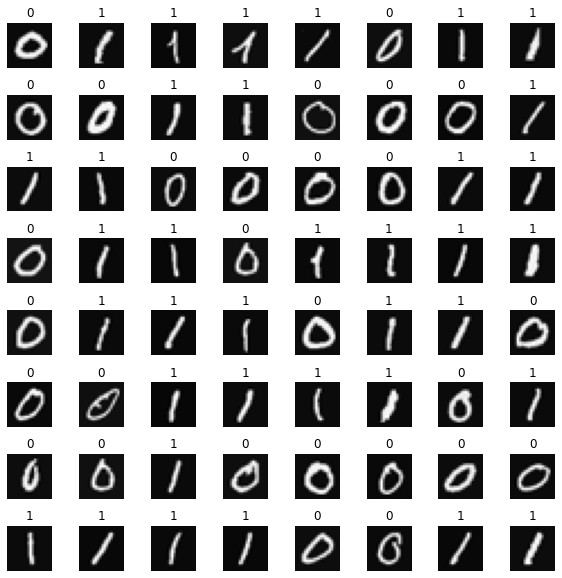

In [38]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# You do not need to modify anything in this cell

m, n = X.shape

fig, axes = plt.subplots(8,8, figsize=(8,8))
fig.tight_layout(pad=0.1)

for i,ax in enumerate(axes.flat):
    # Select random indices
    random_index = np.random.randint(m)

    # Select rows corresponding to the random indices and
    # reshape the image
    X_random_reshaped = X[random_index].reshape((20,20)).T

    # Display the image
    ax.imshow(X_random_reshaped, cmap='gray')

    # Display the label above the image
    ax.set_title(y[random_index,0])
    ax.set_axis_off()

#### Model representation

The neural network you will use in this assignment is shown in the figure below.
- This has three dense layers with sigmoid activations.
    - Recall that our inputs are pixel values of digit images.
    - Since the images are of size $20\times20$, this gives us $400$ inputs

<img src="../../img/2_advanced_learning_algorithms/week1_practice/model_representation.png" width="600">

- The parameters have dimensions that are sized for a neural network with $25$ units in layer 1, $15$ units in layer 2 and $1$ output unit in layer 3.

    - Recall that the dimensions of these parameters are determined as follows:
        - If network has $s_{in}$ units in a layer and $s_{out}$ units in the next layer, then
            - $W$ will be of dimension $s_{in} \times s_{out}$.
            - $b$ will a vector with $s_{out}$ elements

    - Therefore, the shapes of `W`, and `b`,  are
        - layer1: The shape of `W1` is (400, 25) and the shape of `b1` is (25,)
        - layer2: The shape of `W2` is (25, 15) and the shape of `b2` is: (15,)
        - layer3: The shape of `W3` is (15, 1) and the shape of `b3` is: (1,)
>**Note:** The bias vector `b` could be represented as a 1-D (n,) or 2-D (1,n) array. Tensorflow utilizes a 1-D representation and this lab will maintain that convention.

#### Tensorflow Model Implementation
Tensorflow models are built layer by layer. A layer's input dimensions ($s_{in}$ above) are calculated for you. You specify a layer's *output dimensions* and this determines the next layer's input dimension. The input dimension of the first layer is derived from the size of the input data specified in the `model.fit` statement below.
>**Note:** It is also possible to add an input layer that specifies the input dimension of the first layer. For example:
`tf.keras.Input(shape=(400,)),    #specify input shape`
We will include that here to illuminate some model sizing.

In [41]:
# UNQ_C1
# GRADED CELL: Sequential model
model = Sequential(
    [
        tf.keras.Input(shape=(400,)),    #specify input size
        ### START CODE HERE ###
        Dense(25, activation='sigmoid', name = 'layer1'),
        Dense(15, activation='sigmoid', name = 'layer2'),
        Dense(1, activation='sigmoid', name = 'layer3')
        ### END CODE HERE ###
    ], name = "my_model"
)
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 25)                10025     
                                                                 
 layer2 (Dense)              (None, 15)                390       
                                                                 
 layer3 (Dense)              (None, 1)                 16        
                                                                 
Total params: 10,431
Trainable params: 10,431
Non-trainable params: 0
_________________________________________________________________


In [42]:
# UNIT TESTS
from public_tests import *

test_c1(model)

All tests passed!


The parameter counts shown in the summary correspond to the number of elements in the weight and bias arrays as shown below.

In [43]:
L1_num_params = 400 * 25 + 25  # W1 parameters  + b1 parameters
L2_num_params = 25 * 15 + 15   # W2 parameters  + b2 parameters
L3_num_params = 15 * 1 + 1     # W3 parameters  + b3 parameters
print("L1 params = ", L1_num_params, ", L2 params = ", L2_num_params, ",  L3 params = ", L3_num_params )

L1 params =  10025 , L2 params =  390 ,  L3 params =  16


Let's further examine the weights to verify that tensorflow produced the same dimensions as we calculated above.

In [45]:
[layer1, layer2, layer3] = model.layers
#### Examine Weights shapes
W1,b1 = layer1.get_weights()
W2,b2 = layer2.get_weights()
W3,b3 = layer3.get_weights()
print(f"W1 shape = {W1.shape}, b1 shape = {b1.shape}")
print(f"W2 shape = {W2.shape}, b2 shape = {b2.shape}")
print(f"W3 shape = {W3.shape}, b3 shape = {b3.shape}")

W1 shape = (400, 25), b1 shape = (25,)
W2 shape = (25, 15), b2 shape = (15,)
W3 shape = (15, 1), b3 shape = (1,)


xx.get_weights returns a NumPy array. One can also access the weights directly in their tensor form. Note the shape of the tensors in the final layer.

In [56]:
print(model.layers[2].weights)

[<tf.Variable 'layer3/kernel:0' shape=(15, 1) dtype=float32, numpy=
array([[ 0.15653116],
       [ 0.53099555],
       [ 0.4945249 ],
       [-0.0046913 ],
       [-0.313268  ],
       [-0.38383365],
       [-0.29523894],
       [ 0.51184314],
       [ 0.44552428],
       [ 0.46356672],
       [-0.426218  ],
       [-0.49010846],
       [-0.44301498],
       [ 0.23380375],
       [-0.4684174 ]], dtype=float32)>, <tf.Variable 'layer3/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]


The following code will define a loss function and run gradient descent to fit the weights of the model to the training data. This will be explained in more detail in the following week.

In [57]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(0.001),
)

model.fit(
    X,y,
    epochs=20
)

Epoch 1/20
32/32 [==============================] - 1s 3ms/step - loss: 0.6141
Epoch 2/20
32/32 [==============================] - 0s 3ms/step - loss: 0.4406
Epoch 3/20
32/32 [==============================] - 0s 4ms/step - loss: 0.2849
Epoch 4/20
32/32 [==============================] - 0s 4ms/step - loss: 0.1867
Epoch 5/20
32/32 [==============================] - 0s 3ms/step - loss: 0.1321
Epoch 6/20
32/32 [==============================] - 0s 3ms/step - loss: 0.0998
Epoch 7/20
32/32 [==============================] - 0s 4ms/step - loss: 0.0790
Epoch 8/20
32/32 [==============================] - 0s 3ms/step - loss: 0.0643
Epoch 9/20
32/32 [==============================] - 0s 4ms/step - loss: 0.0538
Epoch 10/20
32/32 [==============================] - 0s 4ms/step - loss: 0.0459
Epoch 11/20
32/32 [==============================] - 0s 3ms/step - loss: 0.0399
Epoch 12/20
32/32 [==============================] - 0s 3ms/step - loss: 0.0352
Epoch 13/20
32/32 [==============================

To run the model on an example to make a prediction, use [Keras `predict`](https://www.tensorflow.org/api_docs/python/tf/keras/Model). The input to `predict` is an array so the single example is reshaped to be two dimensional.

In [61]:
prediction = model.predict(X[0].reshape(1,400))  # a zero
print(f" predicting a zero: {prediction}")
prediction = model.predict(X[800].reshape(1,400))  # a one
print(f" predicting a one:  {prediction}")

 predicting a zero: [[0.01352784]]
 predicting a one:  [[0.9891583]]


The output of the model is interpreted as a probability. In the first example above, the input is a zero. The model predicts the probability that the input is a one is nearly zero.
In the second example, the input is a one. The model predicts the probability that the input is a one is nearly one.
As in the case of logistic regression, the probability is compared to a threshold to make a final prediction.

In [62]:
if prediction >= 0.5:
    yhat = 1
else:
    yhat = 0
print(f"prediction after threshold: {yhat}")

prediction after threshold: 1


Let's compare the predictions vs the labels for a random sample of 64 digits. This takes a moment to run.

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# You do not need to modify anything in this cell

m, n = X.shape

fig, axes = plt.subplots(8,8, figsize=(8,8))
fig.tight_layout(pad=0.1,rect=[0, 0.03, 1, 0.92]) #[left, bottom, right, top]

for i,ax in enumerate(axes.flat):
    # Select random indices
    random_index = np.random.randint(m)

    # Select rows corresponding to the random indices and
    # reshape the image
    X_random_reshaped = X[random_index].reshape((20,20)).T

    # Display the image
    ax.imshow(X_random_reshaped, cmap='gray')

    # Predict using the Neural Network
    prediction = model.predict(X[random_index].reshape(1,400))
    if prediction >= 0.5:
        yhat = 1
    else:
        yhat = 0

    # Display the label above the image
    ax.set_title(f"{y[random_index,0]},{yhat}")
    ax.set_axis_off()
fig.suptitle("Label, yhat", fontsize=16)
plt.show()